In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
# Load dataset
df = pd.read_csv('american_bankruptcy.csv')
# Rename columns X1 to X18 to actual financial terms
df.rename(columns={
    'X1': 'Current assets',
    'X2': 'Cost of goods sold',
    'X3': 'Depreciation and amortization',
    'X4': 'EBITDA',
    'X5': 'Inventory',
    'X6': 'Net Income',
    'X7': 'Total Receivables',
    'X8': 'Market Value',
    'X9': 'Net Sales',
    'X10': 'Total Assets',
    'X11': 'Total Long-term Debt',
    'X12': 'EBIT',
    'X13': 'Gross Profit',
    'X14': 'Total Current Liabilities',
    'X15': 'Retained Earnings',
    'X16': 'Total Revenue',
    'X17': 'Total Liabilities',
    'X18': 'Total Operating Expenses'
}, inplace=True)

# Inspect data to ensure columns have been renamed correctly
print(df.info())
print(df.describe())
# Calculate Debt-to-Equity Ratio (Total Liabilities / Total Assets)
df['Debt_Equity_Ratio'] = df['Total Liabilities'] / df['Total Assets']

# Calculate the Altman Z-Score
df['Altman_Z_Score'] = (1.2 * (df['Current assets'] - df['Total Current Liabilities']) / df['Total Assets'] +
                        1.4 * (df['Retained Earnings'] / df['Total Assets']) +
                        3.3 * (df['EBIT'] / df['Total Assets']) +
                        0.6 * (df['Market Value'] / df['Total Liabilities']) +
                        1.0 * (df['Net Sales'] / df['Total Assets']))

# Check the new columns to confirm
print(df[['Debt_Equity_Ratio', 'Altman_Z_Score']].head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78682 entries, 0 to 78681
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   company_name                   78682 non-null  object 
 1   status_label                   78682 non-null  object 
 2   year                           78682 non-null  int64  
 3   Current assets                 78682 non-null  float64
 4   Cost of goods sold             78682 non-null  float64
 5   Depreciation and amortization  78682 non-null  float64
 6   EBITDA                         78682 non-null  float64
 7   Inventory                      78682 non-null  float64
 8   Net Income                     78682 non-null  float64
 9   Total Receivables              78682 non-null  float64
 10  Market Value                   78682 non-null  float64
 11  Net Sales                      78682 non-null  float64
 12  Total Assets                   78682 non-null 

In [4]:
# Convert 'status_label' to numerical values
# 'alive' -> 0 (Not Bankrupt), 'failed' -> 1 (Bankrupt)
df['status_label'] = df['status_label'].apply(lambda x: 1 if x == 'failed' else 0)

# Check the conversion
print(df['status_label'].value_counts())


status_label
0    73462
1     5220
Name: count, dtype: int64


In [6]:
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Separate features and target variable (including the new financial metrics)
X = df.drop(columns=['company_name', 'status_label', 'year'])  # Drop unnecessary columns
y = df['status_label']  # Target variable
# 2. Split data into training and testing sets (80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Handle class imbalance using Borderline-SMOTE (with new features)
borderline_smote = BorderlineSMOTE(random_state=42, kind='borderline-1')
X_train_balanced, y_train_balanced = borderline_smote.fit_resample(X_train, y_train)

# 4. Scale the features
scaler = StandardScaler()
X_train_balanced = scaler.fit_transform(X_train_balanced)
X_test = scaler.transform(X_test)

# Check the shape of the balanced training data
print("Balanced training set shape:", X_train_balanced.shape)
print("Original test set shape:", X_test.shape)


Balanced training set shape: (117538, 20)
Original test set shape: (15737, 20)


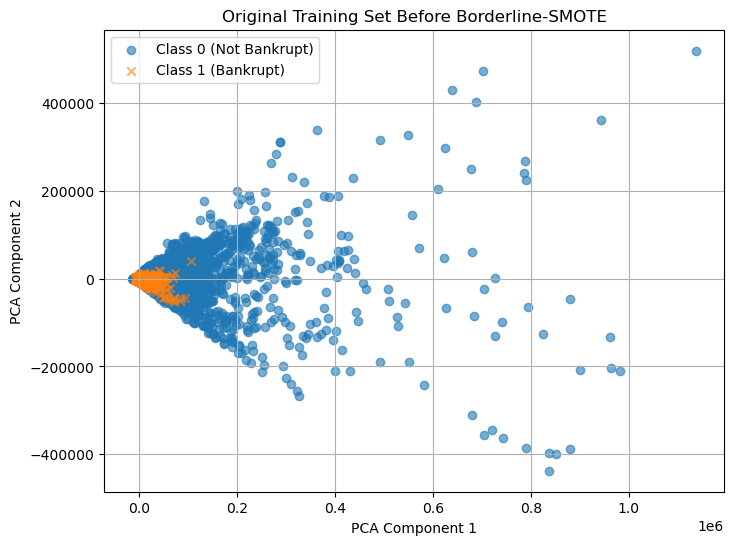

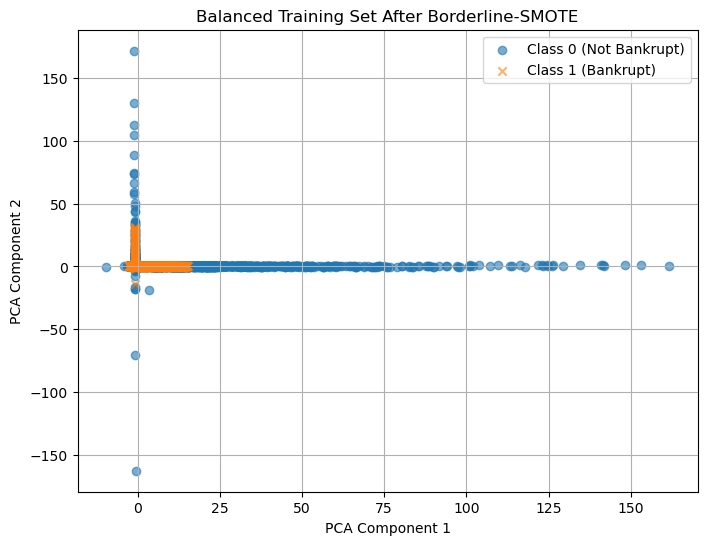

In [8]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Function to visualize the data
def visualize_data(X, y, title):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)  # Reduce to 2 components for 2D plotting
    
    plt.figure(figsize=(8,6))
    plt.scatter(X_pca[y == 0][:, 0], X_pca[y == 0][:, 1], label="Class 0 (Not Bankrupt)", alpha=0.6)
    plt.scatter(X_pca[y == 1][:, 0], X_pca[y == 1][:, 1], label="Class 1 (Bankrupt)", alpha=0.6, marker='x')
    
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize original training set before Borderline-SMOTE
visualize_data(X_train, y_train, title="Original Training Set Before Borderline-SMOTE")

# Visualize the balanced training set after applying Borderline-SMOTE
visualize_data(X_train_balanced, y_train_balanced, title="Balanced Training Set After Borderline-SMOTE")


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
# List of models to evaluate
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Dictionary to store the trained models
trained_models = {}

# Evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train_balanced, y_train_balanced)
    
    # Store the trained model in the dictionary
    trained_models[model_name] = model
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Get probabilities for ROC-AUC

    # Print evaluation metrics
    print(f"Model: {model_name}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nROC AUC Score:")
    print(roc_auc_score(y_test, y_pred_proba))
    print("-" * 60)

# The trained models are now stored in the trained_models dictionary

Model: Logistic Regression
Confusion Matrix:
[[5210 9483]
 [ 166  878]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.35      0.52     14693
           1       0.08      0.84      0.15      1044

    accuracy                           0.39     15737
   macro avg       0.53      0.60      0.34     15737
weighted avg       0.91      0.39      0.49     15737


ROC AUC Score:
0.6785071500412139
------------------------------------------------------------
Model: Decision Tree
Confusion Matrix:
[[12950  1743]
 [  560   484]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92     14693
           1       0.22      0.46      0.30      1044

    accuracy                           0.85     15737
   macro avg       0.59      0.67      0.61     15737
weighted avg       0.91      0.85      0.88     15737


ROC AUC Score:
0.6724868072554161
-------------------------

In [12]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Define base models
base_models = [
    ('logistic', LogisticRegression(random_state=42)),
    ('decision_tree', DecisionTreeClassifier(random_state=42)),
    ('random_forest', RandomForestClassifier(random_state=42)),
    ('gradient_boosting', GradientBoostingClassifier(random_state=42))
]

# Define meta-learner
meta_model = LogisticRegression(random_state=42)

# Create stacking classifier
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

# Train stacking model on the balanced training set
stacking_model.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_pred_stack = stacking_model.predict(X_test)
y_pred_stack_proba = stacking_model.predict_proba(X_test)[:, 1]  # Get probabilities for ROC-AUC

# Print evaluation metrics for the stacking model
print("Stacking Model")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_stack))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_stack))
print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_pred_stack_proba))


Stacking Model
Confusion Matrix:
[[14409   284]
 [  652   392]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     14693
           1       0.58      0.38      0.46      1044

    accuracy                           0.94     15737
   macro avg       0.77      0.68      0.71     15737
weighted avg       0.93      0.94      0.93     15737


ROC AUC Score:
0.844723475849135


In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
base_models = [
    ('logistic', LogisticRegression(random_state=42)),
    ('decision_tree', DecisionTreeClassifier(random_state=42)),
    ('random_forest', RandomForestClassifier(random_state=42)),
    ('gradient_boosting', GradientBoostingClassifier(random_state=42))
]

# Set Random Forest as the final meta-learner
meta_model_rf = RandomForestClassifier(random_state=42, n_estimators=50)

# Create the stacking classifier with Random Forest as the meta-learner
stacking_model1 = StackingClassifier(estimators=base_models, final_estimator=meta_model_rf, cv=5)  # Reduced cv to 3

# Define a StratifiedKFold for better progress tracking
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Train the stacking model and print evaluation metrics
print("\nTraining Stacking Model with Random Forest Meta-Learner...")

for fold, (train_index, val_index) in enumerate(kf.split(X_train_balanced, y_train_balanced), 1):
    X_train_fold, X_val_fold = X_train_balanced[train_index], X_train_balanced[val_index]
    y_train_fold, y_val_fold = y_train_balanced[train_index], y_train_balanced[val_index]
    
    stacking_model1.fit(X_train_fold, y_train_fold)  # Train on current fold
    
    # Print progress
    print(f"  Training fold {fold}/{kf.n_splits}...")

# Make predictions on the test set
y_pred = stacking_model1.predict(X_test)
y_pred_proba = stacking_model1.predict_proba(X_test)[:, 1]

# Print evaluation metrics
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_pred_proba))


Training Stacking Model with Random Forest Meta-Learner...
  Training fold 1/3...
  Training fold 2/3...
  Training fold 3/3...

Confusion Matrix:
[[14286   407]
 [  656   388]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     14693
           1       0.49      0.37      0.42      1044

    accuracy                           0.93     15737
   macro avg       0.72      0.67      0.69     15737
weighted avg       0.93      0.93      0.93     15737


ROC AUC Score:
0.7966070845110124


In [23]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

# Define the parameter grid for Logistic Regression
logistic_params = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l2', 'none'],      # Regularization type
    'solver': ['lbfgs', 'liblinear', 'saga']  # Optimizers
}

logistic_model = LogisticRegression(random_state=42)

# Perform Randomized Search
logistic_search = RandomizedSearchCV(estimator=logistic_model,
                                     param_distributions=logistic_params,
                                     n_iter=10,
                                     cv=5,
                                     verbose=1,
                                     n_jobs=-1,
                                     random_state=42)

logistic_search.fit(X_train_balanced, y_train_balanced)

# Best Logistic Regression hyperparameters
best_logistic = logistic_search.best_estimator_
print(f"Best Logistic Regression Hyperparameters: {logistic_search.best_params_}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
30 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\hp\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\hp\anaconda3\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\hp\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\_p

Best Logistic Regression Hyperparameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 100}


In [24]:
from sklearn.tree import DecisionTreeClassifier

# Define the parameter grid for Decision Tree
tree_params = {
    'max_depth': [5, 10, 20, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

tree_model = DecisionTreeClassifier(random_state=42)

# Perform Randomized Search
tree_search = RandomizedSearchCV(estimator=tree_model,
                                 param_distributions=tree_params,
                                 n_iter=10,
                                 cv=5,
                                 verbose=1,
                                 n_jobs=-1,
                                 random_state=42)

tree_search.fit(X_train_balanced, y_train_balanced)

# Best Decision Tree hyperparameters
best_tree = tree_search.best_estimator_
print(f"Best Decision Tree Hyperparameters: {tree_search.best_params_}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Decision Tree Hyperparameters: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None, 'criterion': 'gini'}


In [25]:
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid for Random Forest
rf_params = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_model = RandomForestClassifier(random_state=42)

# Perform Randomized Search
rf_search = RandomizedSearchCV(estimator=rf_model,
                               param_distributions=rf_params,
                               n_iter=10,
                               cv=5,
                               verbose=1,
                               n_jobs=-1,
                               random_state=42)

rf_search.fit(X_train_balanced, y_train_balanced)

# Best Random Forest hyperparameters
best_rf = rf_search.best_estimator_
print(f"Best Random Forest Hyperparameters: {rf_search.best_params_}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Random Forest Hyperparameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None, 'bootstrap': False}


In [26]:
from sklearn.ensemble import GradientBoostingClassifier

# Define the parameter grid for Gradient Boosting
gb_params = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gb_model = GradientBoostingClassifier(random_state=42)

# Perform Randomized Search
gb_search = RandomizedSearchCV(estimator=gb_model,
                               param_distributions=gb_params,
                               n_iter=10,
                               cv=5,
                               verbose=1,
                               n_jobs=-1,
                               random_state=42)

gb_search.fit(X_train_balanced, y_train_balanced)

# Best Gradient Boosting hyperparameters
best_gb = gb_search.best_estimator_
print(f"Best Gradient Boosting Hyperparameters: {gb_search.best_params_}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Gradient Boosting Hyperparameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10, 'learning_rate': 0.1}


In [27]:
from sklearn.ensemble import StackingClassifier

# Define meta-learner (Logistic Regression, tuned previously)
meta_model = LogisticRegression(random_state=42)

# Create the Stacking Classifier with tuned base models
stacking_model_tuned = StackingClassifier(estimators=[
    ('logistic', best_logistic),
    ('decision_tree', best_tree),
    ('random_forest', best_rf),
    ('gradient_boosting', best_gb)
], final_estimator=meta_model, cv=5)

# Train the stacking model
stacking_model_tuned.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_pred_stack_tuned = stacking_model_tuned.predict(X_test)
y_pred_stack_proba_tuned = stacking_model_tuned.predict_proba(X_test)[:, 1]

# Evaluate tuned model performance
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("Tuned Stacking Model")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_stack_tuned))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_stack_tuned))
print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_pred_stack_proba_tuned))


Tuned Stacking Model
Confusion Matrix:
[[14383   310]
 [  676   368]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     14693
           1       0.54      0.35      0.43      1044

    accuracy                           0.94     15737
   macro avg       0.75      0.67      0.70     15737
weighted avg       0.93      0.94      0.93     15737


ROC AUC Score:
0.8517767733116586


PermutationExplainer explainer: 15738it [8:10:22,  1.87s/it]                                                           


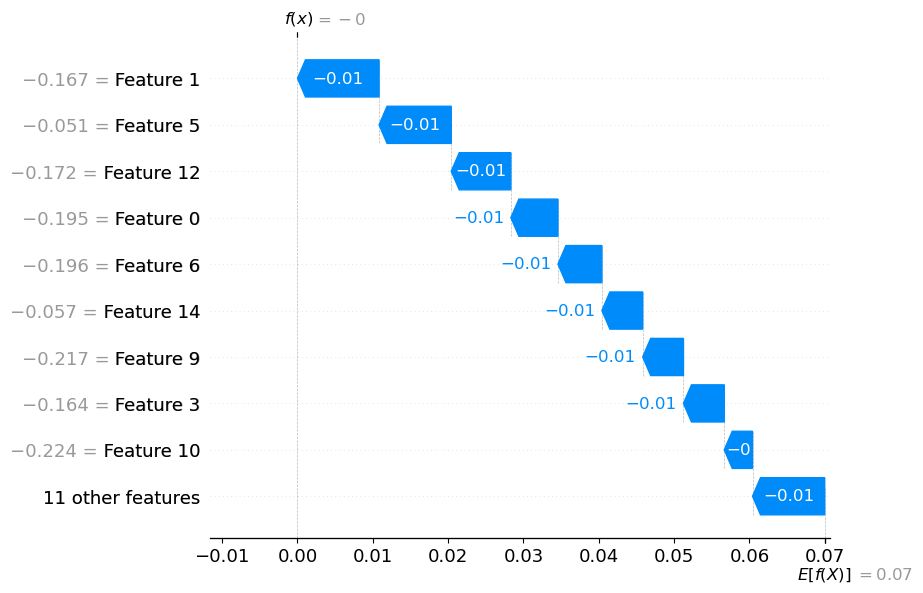

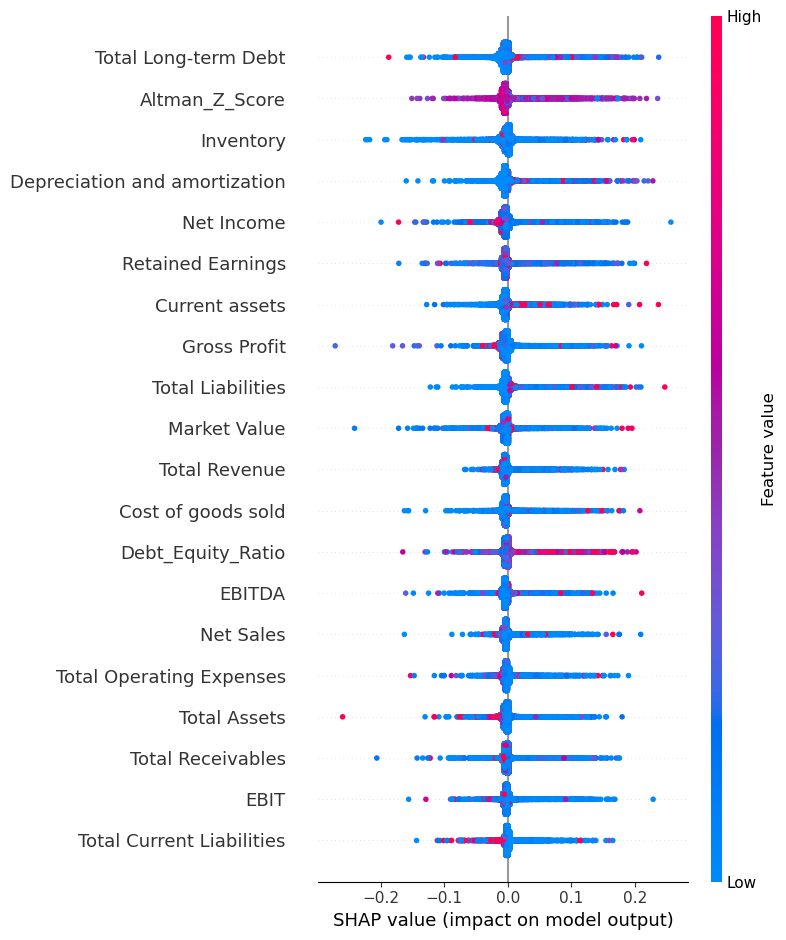

In [52]:
import shap

# Initialize the SHAP Permutation Explainer
explainer_perm = shap.PermutationExplainer(stacking_model_tuned.predict, X_test)

# Compute SHAP values
shap_values_perm = explainer_perm(X_test)

# Visualize SHAP values for one instance (e.g., the first instance in the test set)
shap.plots.waterfall(shap_values_perm[0])  # Explanation for the first instance

# Summary plot for all instances
shap.summary_plot(shap_values_perm, X_test, feature_names=X.columns)


In [36]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [48]:
pip install lime


     ---------------------------------------- 0.0/275.7 kB ? eta -:--:--
     ---------------------------------------- 0.0/275.7 kB ? eta -:--:--
     - -------------------------------------- 10.2/275.7 kB ? eta -:--:--
     - -------------------------------------- 10.2/275.7 kB ? eta -:--:--
     ---- -------------------------------- 30.7/275.7 kB 262.6 kB/s eta 0:00:01
     -------- ---------------------------- 61.4/275.7 kB 365.7 kB/s eta 0:00:01
     -------------- --------------------- 112.6/275.7 kB 504.4 kB/s eta 0:00:01
     ---------------------- ------------- 174.1/275.7 kB 700.2 kB/s eta 0:00:01
     -------------------------------- --- 245.8/275.7 kB 838.1 kB/s eta 0:00:01
     ------------------------------------ 275.7/275.7 kB 850.9 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283842 sha256=1f95bea3b0d4de78ee11de1d6d0fe8dc9b26093

In [50]:
from lime.lime_tabular import LimeTabularExplainer

# Initialize the LIME explainer
explainer = LimeTabularExplainer(X_train_balanced, feature_names=X.columns, class_names=['Not Bankrupt', 'Bankrupt'], mode='classification')

# Explain a single prediction
i = 0  # Index of the instance in X_test you want to explain
exp = explainer.explain_instance(X_test[i], stacking_model_tuned.predict_proba)

# Show the explanation
exp.show_in_notebook(show_table=True)


In [54]:
from lime.lime_tabular import LimeTabularExplainer

# Initialize the LIME explainer
explainer = LimeTabularExplainer(X_train_balanced, 
                                 feature_names=X.columns, 
                                 class_names=['Not Bankrupt', 'Bankrupt'], 
                                 mode='classification')

# Explain a single prediction
i = 0  # Index of the instance in X_test you want to explain
exp = explainer.explain_instance(X_test[i], stacking_model_tuned.predict_proba)

# Show the explanation in a notebook
exp.show_in_notebook(show_table=True)

# Extract feature contributions (top features contributing to the prediction)
explanation_list = exp.as_list()

# Generate a textual recommendation
recommendation = []
for feature, contribution in explanation_list:
    if contribution > 0:
        recommendation.append(f"Increase in '{feature}' increases the likelihood of bankruptcy.")
    else:
        recommendation.append(f"Increase in '{feature}' decreases the likelihood of bankruptcy.")

# Join the recommendations into a single paragraph
textual_recommendation = " ".join(recommendation)

# Display the recommendation
print("Pointwise recommendation based on LIME analysis:")
print(textual_recommendation)


Pointwise recommendation based on LIME analysis:
Increase in 'Market Value <= -0.16' decreases the likelihood of bankruptcy. Increase in '-0.21 < Current assets <= -0.19' decreases the likelihood of bankruptcy. Increase in '-0.18 < Net Sales <= -0.11' decreases the likelihood of bankruptcy. Increase in '-0.06 < Net Income <= -0.04' decreases the likelihood of bankruptcy. Increase in '-0.21 < Total Current Liabilities <= -0.19' increases the likelihood of bankruptcy. Increase in '-0.18 < Total Operating Expenses <= -0.11' decreases the likelihood of bankruptcy. Increase in '-0.07 < Retained Earnings <= -0.05' increases the likelihood of bankruptcy. Increase in '-0.20 < Depreciation and amortization <= -0.19' decreases the likelihood of bankruptcy. Increase in '-0.23 < Total Assets <= -0.21' increases the likelihood of bankruptcy. Increase in '-0.18 < Total Revenue <= -0.11' decreases the likelihood of bankruptcy.


In [56]:
from lime.lime_tabular import LimeTabularExplainer

# Initialize the LIME explainer
explainer = LimeTabularExplainer(X_train_balanced, feature_names=X.columns, class_names=['Not Bankrupt', 'Bankrupt'], mode='classification')

# Explain a single prediction
i = 0  # Index of the instance in X_test you want to explain
exp = explainer.explain_instance(X_test[i], stacking_model_tuned.predict_proba)

# Get the list of features and their contributions from LIME's explanation
explanation_list = exp.as_list()

# Create lists to store the factors that increase and decrease the likelihood of bankruptcy
increase_risk = []
decrease_risk = []

# Categorize the feature contributions into two groups
for feature, contribution in explanation_list:
    if contribution > 0:
        increase_risk.append(f"{feature}")
    else:
        decrease_risk.append(f"{feature}")

# Format the output in a clear and structured way
print("Pointwise Recommendation based on LIME Analysis:\n")

print("**Factors that Decrease the Likelihood of Bankruptcy:**")
for feature in decrease_risk:
    print(f"- {feature}")

print("\n**Factors that Increase the Likelihood of Bankruptcy:**")
for feature in increase_risk:
    print(f"- {feature}")

# Show the explanation in a notebook (if you're using a notebook environment)
exp.show_in_notebook(show_table=True)


Pointwise Recommendation based on LIME Analysis:

**Factors that Decrease the Likelihood of Bankruptcy:**
- Market Value <= -0.16
- -0.21 < Current assets <= -0.19
- -0.18 < Total Operating Expenses <= -0.11
- -0.06 < Net Income <= -0.04
- -0.18 < Total Revenue <= -0.11
- -0.18 < Net Sales <= -0.11
- -0.14 < EBIT <= -0.09

**Factors that Increase the Likelihood of Bankruptcy:**
- -0.21 < Total Current Liabilities <= -0.19
- -0.18 < Inventory <= -0.11
- -0.24 < Total Long-term Debt <= -0.14


In [58]:
import joblib
joblib.dump(stacking_model_tuned, 'stacked_model_tunedd.pkl')


['stacked_model_tunedd.pkl']

In [60]:
import numpy as np

# Assuming `X_train_balanced` is your training data in numpy array format
np.save('X_train_balanced.npy', X_train_balanced)


In [62]:
print(X_train_balanced.shape)
print(len(feature_names))


(117538, 20)


NameError: name 'feature_names' is not defined

In [74]:
X_train_balanced.info
print(len(feature_names))


AttributeError: 'numpy.ndarray' object has no attribute 'info'

In [1]:
import tkinter as tk
from tkinter import messagebox
import numpy as np
from lime.lime_tabular import LimeTabularExplainer

# Define a function to calculate Altman Z-Score
def calculate_altman_z(features):
    current_assets, total_current_liabilities, retained_earnings, total_assets, ebit, market_value, total_liabilities, net_sales = features
    z_score = (1.2 * (current_assets - total_current_liabilities) / total_assets +
               1.4 * (retained_earnings / total_assets) +
               3.3 * (ebit / total_assets) +
               0.6 * (market_value / total_liabilities) +
               1.0 * (net_sales / total_assets))
    return z_score

# Define interpretation for Altman Z-Score
def interpret_altman_z(z_score):
    if z_score > 2.99:
        return "Low risk of bankruptcy."
    elif 1.81 < z_score <= 2.99:
        return "Moderate risk of bankruptcy."
    else:
        return "High risk of bankruptcy."

# Function to get LIME explanation
def get_lime_explanation(features):
    exp = explainer.explain_instance(features, stacking_model_tuned.predict_proba)
    exp.show_in_notebook(show_table=True)
    return "LIME explanation generated. Check the notebook."

# Function to handle form submission
def submit():
    try:
        # Collect user inputs
        features = [float(entries[i].get()) for i in range(18)]
        
        # Calculate Altman Z-Score
        z_score = calculate_altman_z(features)
        interpretation = interpret_altman_z(z_score)
        
        # Display Altman Z-Score and interpretation
        messagebox.showinfo("Altman Z-Score", f"Z-Score: {z_score}\nInterpretation: {interpretation}")
        
        # Prepare for LIME explanation
        scaled_features = scaler.transform([features])  # Scale user input features
        lime_message = get_lime_explanation(scaled_features[0])
        messagebox.showinfo("LIME Explanation", lime_message)
        
    except ValueError:
        messagebox.showerror("Input Error", "Please ensure all inputs are numerical.")

# Initialize Tkinter window
root = tk.Tk()
root.title("Bankruptcy Prediction Tool")

# List of feature names
feature_names = [
    "Current assets", "Cost of goods sold", "Depreciation and amortization", "EBITDA", "Inventory", 
    "Net Income", "Total Receivables", "Market Value", "Net Sales", "Total Assets", "Total Long-term Debt",
    "EBIT", "Gross Profit", "Total Current Liabilities", "Retained Earnings", "Total Revenue", 
    "Total Liabilities", "Total Operating Expenses"
]

# Create a list of Entry widgets for each feature
entries = []
for idx, feature in enumerate(feature_names):
    label = tk.Label(root, text=feature)
    label.grid(row=idx, column=0, padx=5, pady=5)
    
    entry = tk.Entry(root)
    entry.grid(row=idx, column=1, padx=5, pady=5)
    entries.append(entry)

# Submit button
submit_button = tk.Button(root, text="Calculate Altman Z-Score and LIME Explanation", command=submit)
submit_button.grid(row=len(feature_names), column=0, columnspan=2, pady=10)

# Run the Tkinter event loop
root.mainloop()


KeyboardInterrupt: 

In [1]:
hi

NameError: name 'hi' is not defined